# Sentinel-2 Annual GeoMAD

* **Products used:** 
[gm_s2_annual](https://explorer.digitalearth.africa/gm_s2_annual)


## Background

Satellite imagery allows us to observe the Earth with significant accuracy and detail. However, missing data &mdash; such as gaps caused by cloud cover &mdash; can make it difficult to put together a meaningful image. 

In order to produce a single, complete view of a certain area, satellite data must be consolidated, stacking measurements from different points in time to create a composite image.

The Digital Earth Africa (DE Africa) Sentinel-2 Annual GeoMAD (**Geo**median and **M**edian **A**bsolute **D**eviations) is a cloud-free composite of Sentinel-2 satellite data compiled for each calendar year between 2017 &ndash; 2020. 

The product combines measurements collected in each year to produce one representative, multi-spectral measurement for every 10m x 10m unit of the African continent. The end result is a comprehensive dataset that can be used to generate true-colour images for visual inspection of anthropogenic or natural landmarks. The full spectral dataset can be used to develop more complex algorithms.

GeoMAD leverages Sentinel-2’s high-frequency flyovers, with the annual time interval allowing for 70 to 140 satellite passes of any given location, helping to scope out perpetually cloudy areas. 
For each 10m x 10m block, invalid data is discarded, and remaining observations are mathematically summarised using the geomedian statistic.

The DE Africa GeoMAD also includes three Median Absolute Deviation (MAD) layers. These are higher-order statistical measurements on variation relative to the geomedian, pre-calculated at the same annual time scale. These layers can be used on their own or together with geomedian to gain insights about the land surface and understand its change over time.

**Important details:**

* Geomedian surface reflectance product
    * Valid scaling range: `1 – 10,000`
    * `0` is `no data`
* Median Absolute Deviation product
    * Valid scaling range: Spectral MAD, Bray-Curtis MAD `0 - 1`, Euclidean MAD `0 - 31,623` 
    * `NaN` is `no data`
* Status: Operational
* Date-range: 2017 &ndash; 2020
* Spatial resolution: 10m

>Note: For a detailed description of DE Africa's GeoMAD service, see the DE Africa [GeoMAD technical docs](https://docs.digitalearthafrica.org/en/latest/data_specs/GeoMAD_specs.html)

## Description

In this notebook we will load GeoMAD data using `dc.load()` to return a time series of satellite images. The returned xarray.Dataset will contain analysis-ready images.

Topics covered include:
1. Inspecting the GeoMAD product and measurements available in the datacube
2. Using the native `dc.load()` function to load in GeoMAD data
    * Geomedian surface reflectance example
    * Median Absolute Deviations example

> Note: GeoMAD cannot be loaded using the datacube `load_ard` function, as the GeoMAD dataset does not contain a Scene Classification Layer (SCL) required for `load_ard`. Invalid pixels have already been removed during the geomedian calculation process.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
import datacube
import numpy as np
import matplotlib.pyplot as plt

from deafrica_tools.plotting import rgb

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='GeoMAD')

## Available products and measurements

### List products

We can use datacube's `list_products` functionality to inspect the DE Africa GeoMAD products that are available in the datacube. The table below shows the product names that we will use to load the data, a brief description of the data, and the satellite instrument that acquired the data.

In [3]:
# List Sentinel-2 products available in DE Africa
dc_products = dc.list_products()
display_columns = ['name', 'description']
dc_products[dc_products.name.str.contains(
    'gm_s2_annual').fillna(
        False)][display_columns].set_index('name')

,description
name,
gm_s2_annual,Surface Reflectance Annual Geometric Median an...
gm_s2_annual_lowres,"Annual Geometric Median, Sentinel-2 - Low Reso..."


### List measurements

We can further inspect the data available for GeoMAD using datacube's `list_measurements` functionality. The table below lists each of the measurements available in the data.


In [4]:
dc_measurements = dc.list_measurements()
dc_measurements.loc['gm_s2_annual']

,name,dtype,units,nodata,aliases,flags_definition
measurement,,,,,,
B02,B02,uint16,1,0,"[band_02, blue]",NaN
B03,B03,uint16,1,0,"[band_03, green]",NaN
B04,B04,uint16,1,0,"[band_04, red]",NaN
B05,B05,uint16,1,0,"[band_05, red_edge_1]",NaN
B06,B06,uint16,1,0,"[band_06, red_edge_2]",NaN
B07,B07,uint16,1,0,"[band_07, red_edge_3]",NaN
B08,B08,uint16,1,0,"[band_08, nir, nir_1]",NaN
B8A,B8A,uint16,1,0,"[band_8a, nir_narrow, nir_2]",NaN
B11,B11,uint16,1,0,"[band_11, swir_1, swir_16]",NaN


## Load GeoMAD data using `dc.load()`

Now that we know what products and measurements are available for the products, we can load data from the datacube using `dc.load`. GeoMAD has fourteen available bands of data, which can be used in a variety of ways.

### Example 1 - surface reflectance

In the first example below, we will load GeoMAD data from the Eye of Africa in the Sahara Desert, Mauritania, from 2020. We will load data from three spectral satellite bands: red, green, and blue. By specifying `output_crs='EPSG:6933'` and `resolution=(-10, 10)`, we request that datacube reproject our data to the African Albers coordinate reference system (CRS), with 10 x 10 m pixels. 

> Note: For a more general discussion of how to load data using the datacube, refer to the [Introduction to loading data](../Beginners_guide/03_Loading_data.ipynb) notebook.

In [5]:
# load data
ds = dc.load(product="gm_s2_annual",
             measurements=['red', 'green', 'blue'],
             x=(-11.46, -11.36),
             y=(21.04, 21.16),
             time=("2020"),
             resolution=(-10, 10),
             output_crs='EPSG:6933'
             )

print(ds)

<xarray.Dataset>
Dimensions:      (time: 1, x: 966, y: 1431)
Coordinates:
  * time         (time) datetime64[ns] 2020-07-01T23:59:59.999999
  * y            (y) float64 2.64e+06 2.64e+06 2.64e+06 ... 2.626e+06 2.626e+06
  * x            (x) float64 -1.106e+06 -1.106e+06 ... -1.096e+06 -1.096e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 2629 2660 2725 2751 ... 4265 4340 4388 4406
    green        (time, y, x) uint16 1934 1955 1998 2014 ... 2724 2769 2796 2807
    blue         (time, y, x) uint16 1338 1353 1377 1385 ... 1569 1594 1609 1613
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref



### Plotting GeoMAD geomedian data

We can plot the data we loaded using the rgb function. By default, the function will plot data as a true colour image using the 'red', 'green', and 'blue' bands.


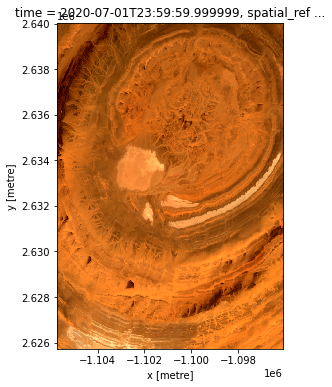

In [6]:
rgb(ds)

### Example 2 - Median Absolute Deviations

In this example, we load the Median Absolute Deviation (MAD) bands of data and plot a false-colour map using those three bands. The area selected here is a few small waterbodies in the Democratic Republic of the Congo. 

In [7]:
# load data
ds = dc.load(product="gm_s2_annual",
             measurements=['smad', 'emad', 'bcmad'],
             x=(27.26, 27.32),
             y=(-10.10, -10.04),
             time=("2020"),
             resolution=(-10, 10),
             output_crs='EPSG:6933'
             )

print(ds)

<xarray.Dataset>
Dimensions:      (time: 1, x: 580, y: 755)
Coordinates:
  * time         (time) datetime64[ns] 2020-07-01T23:59:59.999999
  * y            (y) float64 -1.274e+06 -1.274e+06 ... -1.282e+06 -1.282e+06
  * x            (x) float64 2.63e+06 2.63e+06 2.63e+06 ... 2.636e+06 2.636e+06
    spatial_ref  int32 6933
Data variables:
    smad         (time, y, x) float32 0.008654406 0.008153832 ... 0.0011159076
    emad         (time, y, x) float32 279.16953 276.89975 ... 507.65945
    bcmad        (time, y, x) float32 0.17998177 0.1778138 ... 0.05100873
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


### Plotting GeoMAD MAD data

MAD data has three bands (SMAD, EMAD, BCMAD) and is therefore well-suited to being visualised in false-colour. This means each of the MADs is assigned to one of the red, green, and blue colour channels of the image.

Inspecting the xarray.Dataset above, we can see that `smad`, `emad` and `bcmad` all have very different orders of magnitude. That means if we plot them as given, for instance if we use the `rgb` function (specifying the argument `bands=["emad", "smad", "bcmad"]` for false-colour), the larger values in `emad` will oversaturate the image (try it!).

To compensate for the different ranges in the dataset, we can scale the data for each of the three bands according to the range of values present in that band. This brings all the MADs to approximately the same order of magnitude. The plot will then reqpresent each MAD more equally, and significant MAD features can be identified by visual inspection.

There are two types of scaling: fixed, and dynamic.

Fixed scaling is useful when you are comparing multiple areas and want to have the same scale on each. It is used in the GeoMAD WMS layer and [Digital Earth Africa Maps](https://maps.digitalearth.africa/) portal for the MADs data.
 > On the Maps portal, select 'Add Data' > 'Satellite images' > 'Surface reflectance' > 'Annual' > 'Annual GeoMAD (Sentinel-2)' to view GeoMAD data.

In this notebook, we will demonstrate a dynamic scale. This scale is automatically adjusted depending on the area of interest selected, depending on the range of data values for each of the MADs. This is more suitable when investigating a certain area of interest as the scale is tailored to the data contained in that area.

The dynamic scale here uses a `log` function transform each MAD. The range is cut off at the 2nd and 98th percentiles, removing extreme outliers.

First, we find the 2nd percentile and 98th percentile of each band. These are our scaling lower and upper bounds.

In [8]:
emad_2percentile = np.percentile(ds.emad.values, 2)
emad_98percentile = np.percentile(ds.emad.values, 98)
smad_2percentile = np.percentile(ds.smad.values, 2)
smad_98percentile = np.percentile(ds.smad.values, 98)
bcmad_2percentile = np.percentile(ds.bcmad.values, 2)
bcmad_98percentile = np.percentile(ds.bcmad.values, 98)

In [9]:
smad_scaling = [np.log(smad_2percentile), np.log(smad_98percentile)]
emad_scaling = [np.log(emad_2percentile), np.log(emad_98percentile)]
bcmad_scaling = [np.log(bcmad_2percentile), np.log(bcmad_98percentile)]

In [10]:
ds['smad'] = (np.log(ds.smad)-smad_scaling[0])/(smad_scaling[1]- smad_scaling[0])
ds['emad'] = (np.log(ds.emad)-emad_scaling[0])/(emad_scaling[1]- emad_scaling[0])
ds['bcmad'] = (np.log(ds.bcmad)-bcmad_scaling[0])/(bcmad_scaling[1]- bcmad_scaling[0])

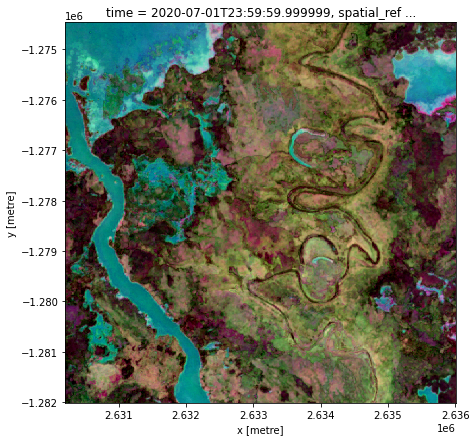

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(7,7))
ds[['emad','smad','bcmad']].squeeze().to_array().plot.imshow(ax=ax, vmin=0, vmax=1.5)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [12]:
print(datacube.__version__)

1.8.4.dev52+g07bc51a5


**Last Tested:**

In [13]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-04-09'